### SSR and FROLs (the greedy algorithms!) examples
There are many algorithms to solve the SINDy regression problem. SSR and FROLs are two popular greedy algorithms. Greedy algorithms iteratively truncate model coefficients, and search for the best model, based on some metric for success. These models work well in practice, but may have weak local convergence and may lack other algorithm guarantees. 

SSR algorithm based on Boninsegna, L., Nüske, F., & Clementi, C. (2018). Sparse learning of stochastic dynamical equations. The Journal of chemical physics, 148(24), 241723 and FROLS algorithm based on Billings, S. A. (2013). Nonlinear system identification: NARMAX methods in the time, frequency, and spatio-temporal domains. John Wiley & Sons.
Jupyter notebook written by Alan Kaptanoglu and Jared Callaham.

Stepwise sparse regression (SSR) solves the problem by iteratively truncating the smallest coefficient during the optimization. There are many ways one can decide to truncate terms. We implement two popular ways: (1) truncating the smallest coefficient at each iteration; (2) chopping each coefficient, computing N - 1 models, and then choosing the model with the lowest residual error.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from utils.odes import lorenz

import pysindy as ps

# Ignore odeint warnings when model is unstable
import warnings
warnings.filterwarnings("ignore")

# Seed the random number generators for reproducibility
np.random.seed(100)

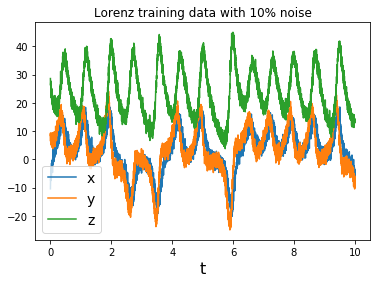

In [2]:
# Generate some training data with added gaussian noise
dt = .002
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [-8, 8, 27]
x_train = solve_ivp(lorenz, t_train_span, x0_train, t_eval=t_train).y.T
rmse = mean_squared_error(x_train, np.zeros((x_train).shape), squared=False)
x_train = x_train + np.random.normal(0, rmse / 10.0, x_train.shape)
feature_names = ['x', 'y', 'z']
                    
ssr_optimizer = ps.SSR()

model = ps.SINDy(optimizer=ssr_optimizer)
model.fit(x_train, t=dt)

for i in range(3):
    plt.plot(t_train, x_train[:, i], label=feature_names[i])
    
plt.xlabel('t', fontsize=16)
plt.legend(fontsize=14)
plt.title('Lorenz training data with 10% noise')
plt.show()

### Define some functions for plotting performance as the greedy algorithms progress

In [3]:
import matplotlib.gridspec as gridspec

def plot_x_dot_fits(x_test, optimizer, dt, n_models):
    plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(3, n_models)
    gs.update(wspace=0.0, hspace=0.0) # set the spacing between axes. 
    for j in range(n_models):
        optimizer.coef_ = np.asarray(optimizer.history_)[j, :, :]

        # Predict derivatives using the learned model
        x_dot_test_predicted = model.predict(x_test)  

        # Compute derivatives with a finite difference method, for comparison
        x_dot_test_computed = model.differentiate(x_test, t=dt)

        for i in range(3):
            plt.subplot(gs[i, j])
            plt.plot(t_test, x_dot_test_computed[:, i],
                        'k', label='numerical derivative')
            plt.plot(t_test, x_dot_test_predicted[:, i],
                        'r', label='model prediction')
            if j == 0:
                plt.ylabel('$\dot ' + feature_names[i] + r'$', fontsize=20)
            if i == 0:
                plt.title('MSE = %.0f' % model.score(x_test, t=dt, metric=mean_squared_error), fontsize=16)
            plt.xlabel('Iteration ' + str(j), fontsize=16)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            ax = plt.gca()
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            plt.grid(True)

        model.print()     
        print('Model ' + str(j) + ', MSE: %f' % model.score(x_test, t=dt, metric=mean_squared_error))
    ax.set_yticklabels([])
    plt.show()

    
def plot_x_fits(x_test, t_test, optimizer, n_models):
    plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(3, n_models)
    gs.update(wspace=0.0, hspace=0.0) # set the spacing between axes. 
    for j in range(n_models):
        optimizer.coef_ = np.asarray(optimizer.history_)[j, :, :]

        # Simulate dynamic system with the identified model
        # Some of these models may diverge, so need to use odeint (which just gives a warning)
        # rather than the default solve_ivp, which crashes with an error
        x_test_sim = model.simulate(x_test[0, :], t_test, integrator='odeint')

        for i in range(3):
            plt.subplot(gs[i, j])
            plt.plot(t_test, x_test[:, i], 'k', label='test trajectory')
            if np.max(np.abs(x_test_sim[:, i])) < 1000:  # check for unstable systems
                plt.plot(t_test, x_test_sim[:, i], 'r', label='model prediction')
            if j == 0:
                plt.ylabel(feature_names[i], fontsize=20)
            if i == 0:
                plt.title('MSE = %.0f' % model.score(x_test, t=dt, metric=mean_squared_error), fontsize=16)
            plt.xlabel('Iteration ' + str(j), fontsize=16)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            ax = plt.gca()
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            plt.grid(True)
   
        print('Model ' + str(j) + ', MSE: %f' % model.score(x_test, t=dt, metric=mean_squared_error))
    ax.set_yticklabels([])
    plt.show()

### Note that the usage is a bit different because we save all the sparse models and we choose our favorite one afterwards. Below we show that we can track the MSE between the predicted and true derivative on a testing trajectory as the algorithm iterates, and then choose the model with the minimum MSE. 

(x0)' = -49.709 1 + 1.439 x0 + 2.666 x1 + 4.810 x2 + 0.638 x0^2 + -0.808 x0 x1 + -0.303 x0 x2 + 0.282 x1^2 + 0.197 x1 x2 + -0.128 x2^2
(x1)' = -23.299 1 + 12.902 x0 + 7.192 x1 + 2.407 x2 + 0.334 x0^2 + -0.461 x0 x1 + -0.593 x0 x2 + 0.162 x1^2 + -0.198 x1 x2 + -0.060 x2^2
(x2)' = 16.193 1 + -6.735 x0 + 3.826 x1 + -4.572 x2 + -0.215 x0^2 + 0.934 x0 x1 + 0.197 x0 x2 + 0.107 x1^2 + -0.111 x1 x2 + 0.062 x2^2
Model 0, MSE: 91.571300
(x0)' = 4.333 1 + 2.549 x0 + 2.739 x1 + -0.726 x2 + 0.409 x0^2 + -0.660 x0 x1 + -0.325 x0 x2 + 0.282 x1^2 + 0.187 x1 x2
(x1)' = 1.750 1 + 13.416 x0 + 7.226 x1 + -0.160 x2 + 0.228 x0^2 + -0.393 x0 x1 + -0.603 x0 x2 + 0.162 x1^2 + -0.203 x1 x2
(x2)' = -9.891 1 + -7.271 x0 + 3.791 x1 + -1.900 x2 + -0.104 x0^2 + 0.863 x0 x1 + 0.207 x0 x2 + 0.107 x1^2 + -0.106 x1 x2
Model 1, MSE: 110.629675
(x0)' = 4.442 1 + -3.305 x0 + 7.818 x1 + -0.706 x2 + 0.401 x0^2 + -0.622 x0 x1 + -0.133 x0 x2 + 0.264 x1^2
(x1)' = -1.207 1 + 13.413 x0 + 7.236 x1 + 0.200 x0^2 + -0.371 x0 x1 + -0.

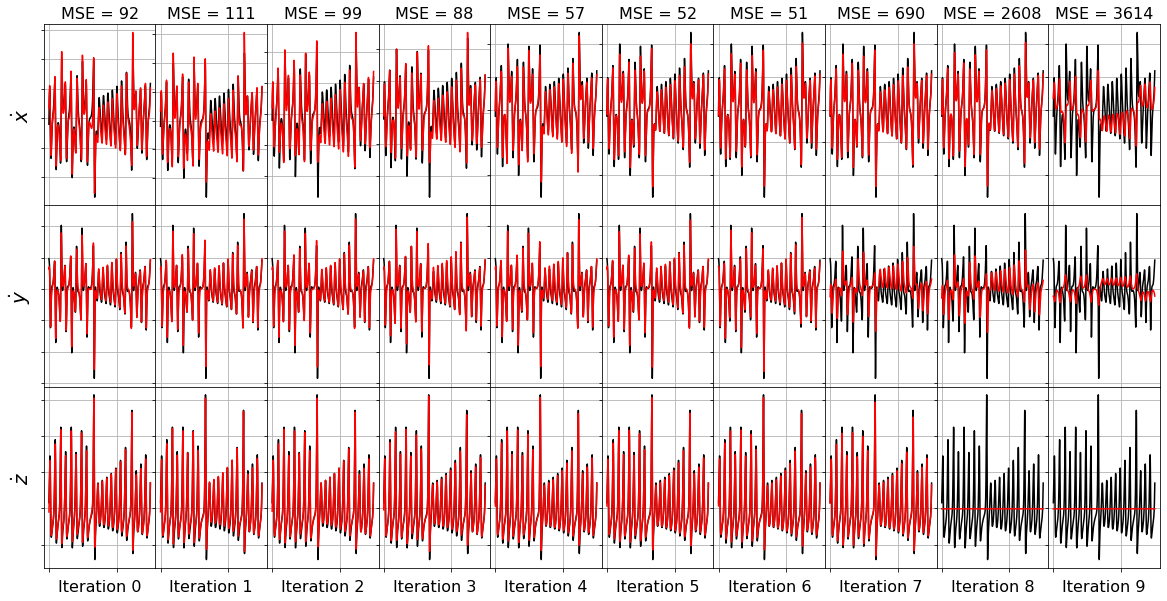

In [4]:
# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 15, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = np.array([8, 7, 15])
x_test = solve_ivp(lorenz, t_test_span, x0_test, t_eval=t_test).y.T
n_models = 10
plot_x_dot_fits(x_test, ssr_optimizer, dt, n_models)

Model 0, MSE: 91.571300
Model 1, MSE: 110.629675
Model 2, MSE: 99.138749
Model 3, MSE: 87.769783
Model 4, MSE: 56.831936
Model 5, MSE: 52.263385
Model 6, MSE: 50.850313
Model 7, MSE: 690.172916
Model 8, MSE: 2608.306782
Model 9, MSE: 3613.943532


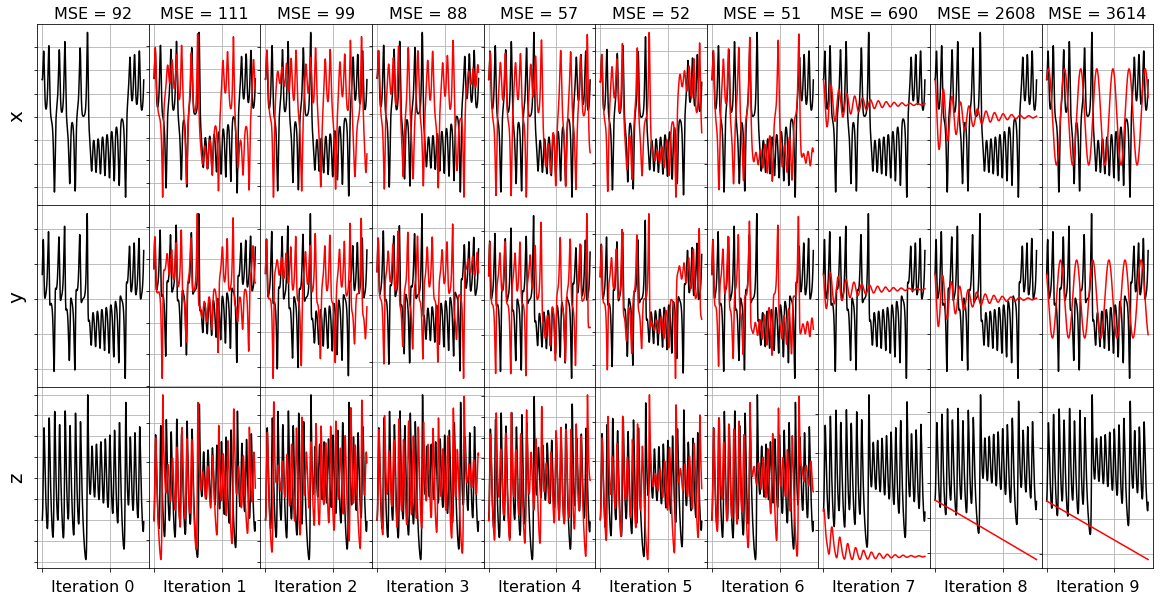

In [5]:
# Repeat plots but now integrate the ODE and compare the test trajectories
plot_x_fits(x_test, t_test, ssr_optimizer, n_models)

Note that some of the frames do not have any red lines... that means the model for this iteration resulted in an unstable model when it was integrated forward. This often happens with nonsparse models!

# Repeat the SSR fitting with the lowest model residual method

In [6]:
ssr_optimizer2 = ps.SSR(criteria="model_residual")
model = ps.SINDy(optimizer=ssr_optimizer2)
model.fit(x_train, t=dt)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['x0', 'x1', 'x2'],
      optimizer=SSR(criteria='model_residual'))

(x0)' = -49.709 1 + 1.439 x0 + 2.666 x1 + 4.810 x2 + 0.638 x0^2 + -0.808 x0 x1 + -0.303 x0 x2 + 0.282 x1^2 + 0.197 x1 x2 + -0.128 x2^2
(x1)' = -23.299 1 + 12.902 x0 + 7.192 x1 + 2.407 x2 + 0.334 x0^2 + -0.461 x0 x1 + -0.593 x0 x2 + 0.162 x1^2 + -0.198 x1 x2 + -0.060 x2^2
(x2)' = 16.193 1 + -6.735 x0 + 3.826 x1 + -4.572 x2 + -0.215 x0^2 + 0.934 x0 x1 + 0.197 x0 x2 + 0.107 x1^2 + -0.111 x1 x2 + 0.062 x2^2
Model 0, MSE: 91.571300
(x0)' = -50.535 1 + 3.522 x1 + 4.929 x2 + 0.640 x0^2 + -0.799 x0 x1 + -0.262 x0 x2 + 0.275 x1^2 + 0.172 x1 x2 + -0.131 x2^2
(x1)' = 13.176 x0 + 7.238 x1 + 0.302 x2 + 0.285 x0^2 + -0.425 x0 x1 + -0.598 x0 x2 + 0.158 x1^2 + -0.202 x1 x2 + -0.016 x2^2
(x2)' = -6.926 x0 + 3.794 x1 + -3.110 x2 + -0.181 x0^2 + 0.909 x0 x1 + 0.200 x0 x2 + 0.109 x1^2 + -0.109 x1 x2 + 0.032 x2^2
Model 1, MSE: 84.655506
(x0)' = 3.979 x1 + 0.382 x2 + 0.533 x0^2 + -0.717 x0 x1 + -0.254 x0 x2 + 0.264 x1^2 + 0.154 x1 x2 + -0.037 x2^2
(x1)' = 13.466 x0 + 7.189 x1 + 0.254 x0^2 + -0.419 x0 x1 + -

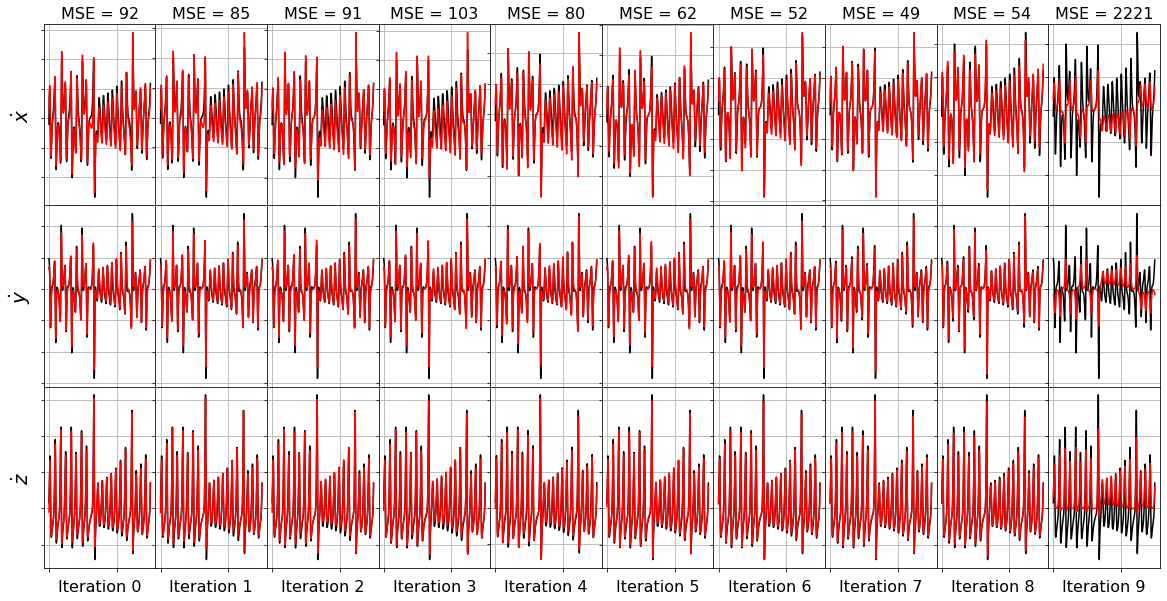

In [7]:
plot_x_dot_fits(x_test, ssr_optimizer2, dt, n_models)

Model 0, MSE: 91.571300
Model 1, MSE: 84.655506
Model 2, MSE: 91.062038
Model 3, MSE: 102.532621
Model 4, MSE: 79.618985
Model 5, MSE: 62.354356
Model 6, MSE: 52.115026
Model 7, MSE: 49.280246
Model 8, MSE: 54.439317
Model 9, MSE: 2221.127476


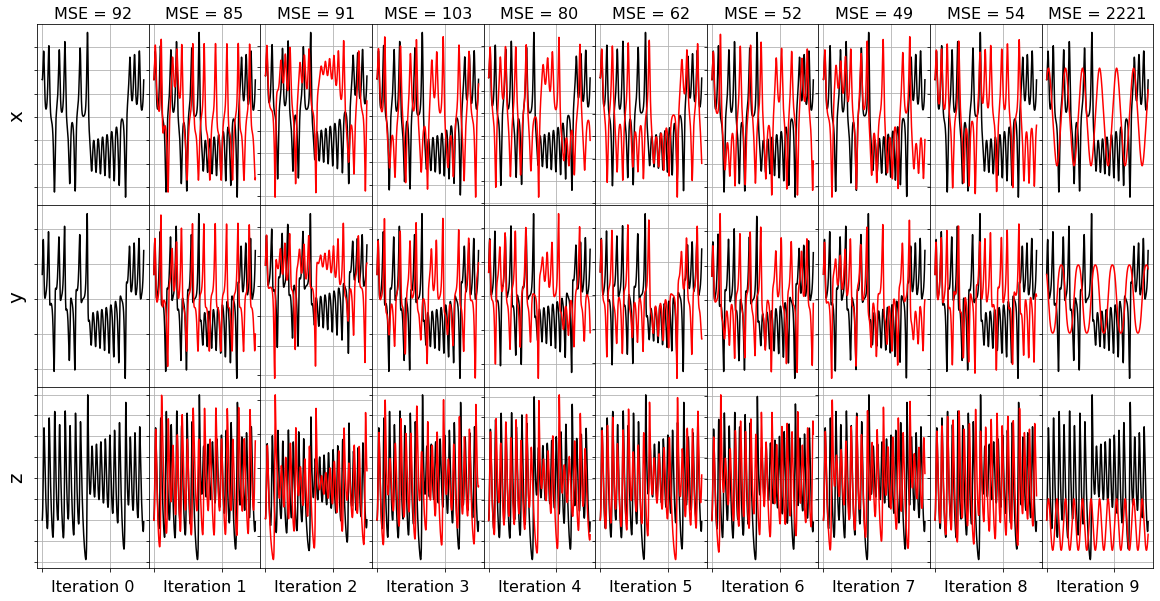

In [8]:
plot_x_fits(x_test, t_test, ssr_optimizer2, n_models)

# FROLS greedy algorithm
Forward Regression Orthogonal Least Squares (FROLS) solves the least-squares regression problem with $L_0$ norm by iteratively selecting the most correlated function in the library. At each step, the candidate functions are orthogonalized with respect to the already-selected functions. The selection criteria is the Error Reduction Ratio, i.e. the normalized increase in the explained output variance due to the addition of a given function to the basis.
### Note that (at least our implementation) performs poorly on noise, generating more unstable models than SSR. FROLs is also different from FROLs because it starts with no coefficients and then at each iteration adds a new nonzero coefficient.

In [9]:
frols_optimizer = ps.FROLS()

model = ps.SINDy(optimizer=frols_optimizer)
model.fit(x_train, t=dt)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['x0', 'x1', 'x2'],
      optimizer=FROLS())

(x0)' = 0.000
(x1)' = 0.000
(x2)' = 0.000
Model 0, MSE: 3882.821055
(x0)' = 2.325 x1
(x1)' = -0.145 x0 x2
(x2)' = 0.397 x1^2
Model 1, MSE: 2173.280970
(x0)' = 0.329 x1 + 0.105 x0 x2
(x1)' = 22.218 x0 + -0.804 x0 x2
(x2)' = -51.910 1 + 0.609 x1^2
Model 2, MSE: 1140.861669
(x0)' = 0.105 x1 + -0.173 x0 x2 + 0.235 x1 x2
(x1)' = 15.343 x0 + 3.261 x1 + -0.684 x0 x2
(x2)' = -31.722 1 + -5.415 x0 x1 + 4.222 x1^2
Model 3, MSE: 7882.367282
(x0)' = -2.713 1 + 0.109 x1 + -0.167 x0 x2 + 0.235 x1 x2
(x1)' = 9.035 x0 + 10.136 x1 + -0.452 x0 x2 + -0.293 x1 x2
(x2)' = -0.439 1 + -2.465 x2 + 0.642 x0 x1 + 0.208 x1^2
Model 4, MSE: 240.136060
(x0)' = -2.959 1 + 1.279 x0 + 0.088 x1 + -0.217 x0 x2 + 0.238 x1 x2
(x1)' = 1.412 x0 + 2.469 x1 + -0.786 x0 x2 + 0.134 x1 x2 + 0.339 x2^2
(x2)' = -0.263 1 + -2.740 x2 + 0.636 x0 x1 + 0.211 x1^2 + 0.010 x2^2
Model 5, MSE: 27423.838663
(x0)' = -0.201 1 + 1.627 x0 + 0.081 x1 + -0.055 x0 x1 + -0.232 x0 x2 + 0.246 x1 x2
(x1)' = 1.408 x0 + 2.463 x1 + 0.055 x0 x1 + -0.779 x

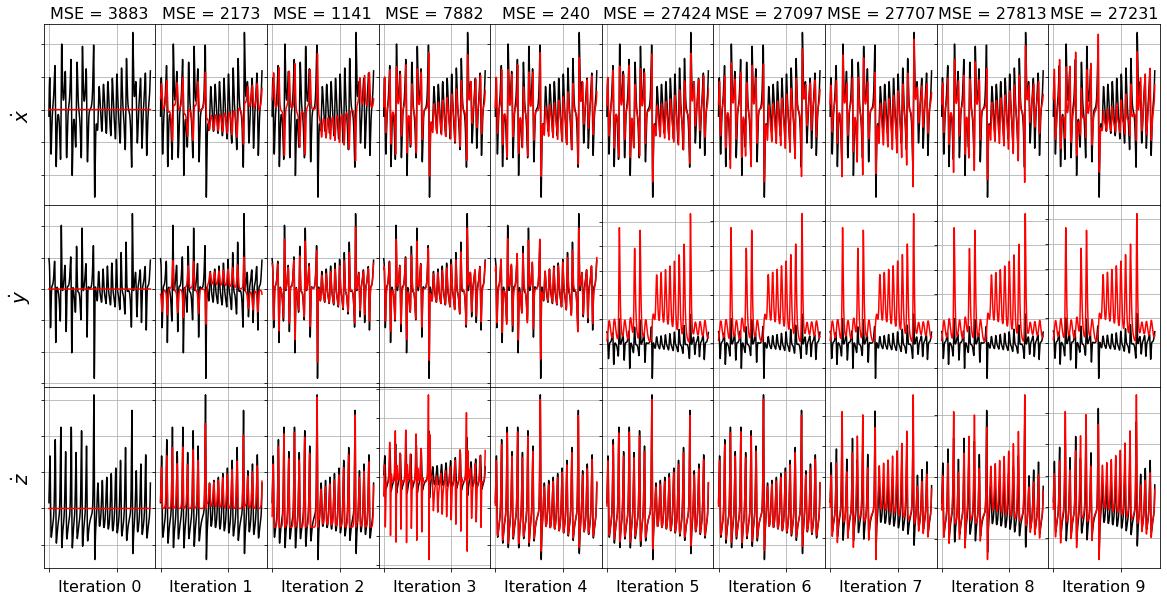

In [10]:
plot_x_dot_fits(x_test, frols_optimizer, dt, n_models)

Model 0, MSE: 3882.821055
Model 1, MSE: 2173.280970
Model 2, MSE: 1140.861669
Model 3, MSE: 7882.367282
Model 4, MSE: 240.136060
Model 5, MSE: 27423.838663
Model 6, MSE: 27097.185021
Model 7, MSE: 27706.829032
Model 8, MSE: 27812.840563
Model 9, MSE: 27231.068262


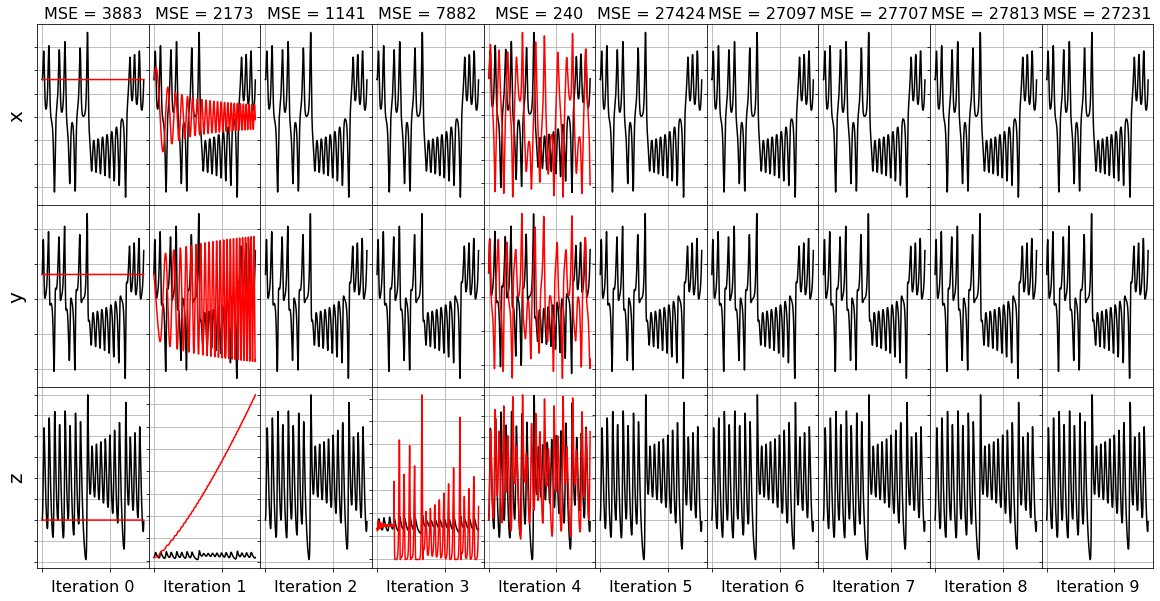

In [11]:
plot_x_fits(x_test, t_test, frols_optimizer, n_models)

### Let's compare all three methods as the noise steadily increases, cross-validated over 10 noise instantiations

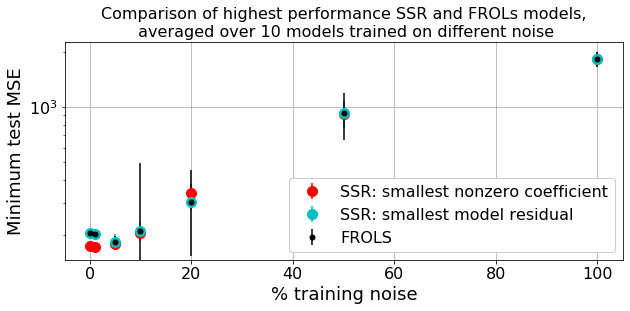

In [12]:
# generate training and testing data
dt = .1
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [-8, 8, 27]
x_train = solve_ivp(lorenz, t_train_span, x0_train, t_eval=t_train).y.T
rmse = mean_squared_error(x_train, np.zeros((x_train).shape), squared=False)
t_test = np.arange(0, 15, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = np.array([8, 7, 15])
x_test = solve_ivp(lorenz, t_test_span, x0_test, t_eval=t_test).y.T

# Cross-validate over 10 discharges for each noise level
n_validation = 10
noise_levels = [rmse / 1000.0, rmse / 100.0, rmse / 20.0, 
                rmse / 10.0, rmse / 5.0, rmse / 2.0, rmse]
criterias = ["coefficient_value", "model_residual"]
final_MSE = np.zeros((3, len(noise_levels), n_validation))
for k, noise_level in enumerate(noise_levels):
    for i in range(n_validation):
        x_noisy = x_train + np.random.normal(0, noise_level, x_train.shape)
        for kk in range(3): 
            if kk == 0:
                optimizer = ps.SSR(criteria="coefficient_value")
            if kk == 1:
                optimizer = ps.SSR(criteria="model_residual")
            if kk == 2:
                optimizer = ps.FROLS()
            model = ps.SINDy(optimizer=optimizer)
            model.fit(x_noisy, t=dt)
            MSE = np.zeros(np.shape(optimizer.history_)[0])
            for j in range(np.shape(optimizer.history_)[0]):
                optimizer.coef_ = np.asarray(optimizer.history_)[j, :, :]
                MSE[j] = model.score(x_test, t=dt, metric=mean_squared_error)
            final_MSE[kk, k, i] = np.min(MSE)
            
average_MSE_cross_validated = np.mean(final_MSE, axis=-1)
std_MSE_cross_validated = np.std(final_MSE, axis=-1)

# Plot average MSE results with error bars.
# Note we are not including a sparsity penalty in the error term.
plt.figure(figsize=(10, 4))
plt.errorbar(noise_levels / rmse * 100, average_MSE_cross_validated[0, :], 
             yerr=std_MSE_cross_validated[0, :], fmt='o', color='r', markersize=10,
             label='SSR: smallest nonzero coefficient')
plt.errorbar(noise_levels / rmse * 100, average_MSE_cross_validated[1, :], 
             yerr=std_MSE_cross_validated[1, :], fmt='o', color='c', markersize=10,
             label='SSR: smallest model residual')
plt.errorbar(noise_levels / rmse * 100, average_MSE_cross_validated[1, :], 
             yerr=std_MSE_cross_validated[2, :], fmt='o', color='k', markersize=5,
             label='FROLS')
plt.yscale('log')
plt.legend(fontsize=16, loc='lower right', framealpha=1.0)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
ax = plt.gca()
plt.xlabel('% training noise', fontsize=18)
plt.ylabel('Minimum test MSE', fontsize=18)
plt.title('Comparison of highest performance SSR and FROLs models,\n '
          'averaged over 10 models trained on different noise', fontsize=16)
plt.savefig('SSR_FROLS_comparison.png')

### Summary
To summarize the findings here, SSR seems to substantially outperform FROLs, at least on this noisy and chaotic data. The "best model" (as measured by the minimal MSE on a testing trajectory) for FROLs often competes with the SSR "best model", but usually with much higher variance. Moreover, almost all the SSR models outperform the FROLs models at the same level of sparsity! So we strongly recommend that on noisy, chaotic data, one uses STLSQ or SSR. The advantage of using SSR is that no hyperparameters are necessarily needed, although one has to choose a favorite or best model at the end. 